In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftfreq, fftshift


import scipy.constants as cst

import sys
sys.path.append('/Users/sebastien/Documents/Code/QRAM/qutip_sims')

from PulseSequence import PulseSequence
from QSwitch import QSwitch

%matplotlib widget
%config InlineBackend.figure_format = 'svg'

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True


Bad key text.latex.unicode in file /Users/sebastien/.matplotlib/stylelib/paper.mplstyle, line 175 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key scatter.linewidths in file /Users/sebastien/.matplotlib/stylelib/paper_2.mplstyle, line 632 ('scatter.linewidths: 0.8')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key text.latex.unicode in file /Users/sebastien/.matplotlib/stylelib/slide.mplstyle, line 175 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/mat

In [2]:
hbar = cst.hbar
h = cst.h
qe = cst.e
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
qubit_freqs = None
alphas = None


EJs = None
ECs = None


rotating_frame = True


qubit_eg = np.array([3450.456887958334, 4766.561902541384])*1e-3
qubit_ef = np.array([3349.983151894969, 4576.680453599131])*1e-3

alphas = (qubit_ef - qubit_eg)

gs = np.zeros((2, 2))
gs[0, 1] = 53.81744103399963e-3
# gs[0, 1] = 0

gs = gs + gs.T

In [4]:
cutoffs = [3, 3]
# cutoffs = [4, 4]

# isCavity = [False, False, False, False]
isCavity = [False, False, False]



qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_eg,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas


In [5]:
H_rot = qram.H*0

for i in range(cutoffs[0]):
    for j in range(cutoffs[1]):
            # for l in range(cutoffs[3]):
            # psi_ids = [i, j, k, l]
            psi_ids = [i, j]
            psi = qram.level_nums_to_name(psi_ids)
            psi_i = qram.level_nums_to_name([i,0])
            psi_j = qram.level_nums_to_name([0,j])
            ket = qram.state(psi)
            ket_i = qram.state(psi_i)
            ket_j = qram.state(psi_j)
            wi = ket_i.dag()*qram.H*ket_i/2/np.pi
            wj = ket_j.dag()*qram.H*ket_j/2/np.pi
            H_rot += (wi + wj)*ket*ket.dag()

e_disp, eig_disp = H_rot.eigenstates()

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels,rotation='vertical',verticalalignment='top')
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 2), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title='', cmax=None, savetitle=None, figsize=(15, 15)):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    cutoffs = rho_test.dims[0]
    print(len(cutoffs))

    if len(cutoffs) == 4:
        labels = [f'$|{qram.level_nums_to_name([i, j, k, l])}\\rangle$' for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
    elif len(cutoffs) == 3:
        labels = [f'$|{qram.level_nums_to_name([i, j, k])}\\rangle$' for i in range(2) for j in range(2) for k in range(2)]
    elif len(cutoffs) == 2:
        labels = [f'$|{qram.level_nums_to_name([i, j])}\\rangle$' for i in range(2) for j in range(2)]
    else:
        labels = [f'$|{qram.level_nums_to_name([i])}\\rangle$' for i in range(2)]
    fig, ax = plt.subplots(2, 1, figsize=figsize)


    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax[0], title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax[1], title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()

In [7]:
# ph_in = -np.pi/2
ph_eg = -np.pi/2
amp_pi = 0.03
amp = 0.1

In [1463]:
seq = PulseSequence(start_time=0)

# if qb_start == 0:
#     wd = qram.get_wd('eg', 'gf', amp=amp, drive_qubit=1, verbose=True)
#     eg_fg = qram.add_sequential_pi_pulse(seq, 'eg', 'gf', amp=amp, drive_qubit=1, phase=ph_eg, t_pulse = 1000, wd=wd)
#     psi0 = qram.state('eg')
# else:
    # wd = qram.get_wd('fg', 'ge', amp=amp, drive_qubit=0, verbose=True)
    # eg_fg = qram.add_sequential_pi_pulse(seq, 'fg', 'ge', amp=amp, drive_qubit=0, phase=ph_eg, t_pulse = 1000, wd=wd)
    # psi0 = qram.state('fg')


state_1 = 'eg'
state_2 = 'gf'
psi_in = (qram.state('gg') + qram.state('eg')).unit()
drive_qubit = 1
t_wait = 30

wd = 3.5e3*2*np.pi

# wd = qram.get_wd(state_1, state_2, amp=amp_pi, drive_qubit=drive_qubit, verbose=True)
# tp = qram.get_Tpi(wd=wd, state1=state_1, state2=state_2, amp=amp, drive_qubit=drive_qubit, type='gauss',verbose=True, sigma_n=5)
eg_ge = qram.add_sequential_pi_pulse(seq, 'ge', 'gg', amp=amp_pi, drive_qubit=1, phase=ph_eg,t_offset=t_wait, sigma_n=5)
# psi0 = qram.state('eg')

1
One photon transition
One qubit gate
wd_base 4.768758908170626
infidelity:  0.0008698805300075829
infidelity:  0.0008698784151378591
infidelity:  0.35721795459885763
infidelity:  0.35721796085015434
infidelity:  0.0012815459075109503
infidelity:  0.0012815497651157415
infidelity:  0.0006939417696522066
infidelity:  0.0006939417679705517
infidelity:  0.0006939416577496083
infidelity:  0.0006939416577513846


In [1452]:
eg_ge = qram.add_sequential_pi_pulse(seq, 'gf', 'ge', amp=amp_pi, drive_qubit=1, type='gauss', phase=ph_eg,t_offset=t_wait, sigma_n=5)
# psi0 = qram.state('eg')

1
One photon transition
One qubit gate
wd_base 4.579613847365523
infidelity:  0.00037149914580691945
infidelity:  0.00037149967826832775
infidelity:  0.06988361686003053
infidelity:  0.06988359560816626
infidelity:  0.0003494361330180773
infidelity:  0.0003494361877127705
infidelity:  0.00034920091944445897
infidelity:  0.00034920091943690945


In [887]:
wd/2/np.pi

3.4483047945833336

[4.7690235758478465] (GHz)
[50.0416462] (ns)
total pulse length 50.04164620487183 ns
[ 0.          0.09013178  0.18026356  0.27039533  0.36052711  0.45065889
  0.54079067  0.63092245  0.72105422  0.811186    0.90131778  0.99144956
  1.08158134  1.17171311  1.26184489  1.35197667  1.44210845  1.53224023
  1.622372    1.71250378  1.80263556  1.89276734  1.98289912  2.07303089
  2.16316267  2.25329445  2.34342623  2.43355801  2.52368978  2.61382156
  2.70395334  2.79408512  2.8842169   2.97434867  3.06448045  3.15461223
  3.24474401  3.33487579  3.42500756  3.51513934  3.60527112  3.6954029
  3.78553468  3.87566645  3.96579823  4.05593001  4.14606179  4.23619357
  4.32632534  4.41645712  4.5065889   4.59672068  4.68685246  4.77698423
  4.86711601  4.95724779  5.04737957  5.13751135  5.22764312  5.3177749
  5.40790668  5.49803846  5.58817023  5.67830201  5.76843379  5.85856557
  5.94869735  6.03882912  6.1289609   6.21909268  6.30922446  6.39935624
  6.48948801  6.57961979  6.66975157  6.7

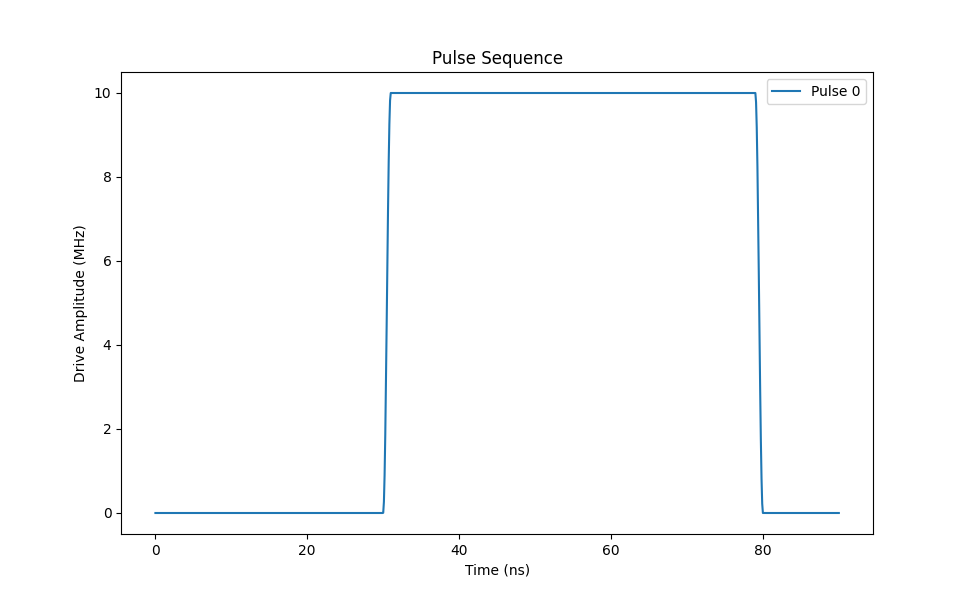

In [1464]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
pulse_freq = seq.get_pulse_freqs()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

times = np.linspace(0, seq.time + 10, 1000)
flat_times = np.array(times).flatten()

fig, ax = plt.subplots(1, 1)

print(flat_times)
for i in range(len(envelope_seq)):
    ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 200)
ax.set_title('Pulse Sequence')
ax.legend()




In [1465]:
psi0 = qram.state(state_1)
result = qram.evolve(psi_in, seq, times, c_ops=None, nsteps=5000)

if rotating_frame:
    print('Rotating frame')
    result_rot = [0*result[i_t] for i_t in range(len(times))]
    # evals, evecs = qram.esys

    for i_t, t in enumerate(tqdm(times)):
        for eval, evec in zip(e_disp, eig_disp):
            result_rot[i_t] += np.exp(1j*eval*t) * evec.overlap(result[i_t]) * evec
else:
    result_rot = result



10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.06s. Est. time left: 00:00:00:00
40.0%. Run time:   0.08s. Est. time left: 00:00:00:00
50.0%. Run time:   0.11s. Est. time left: 00:00:00:00
60.0%. Run time:   0.14s. Est. time left: 00:00:00:00
70.0%. Run time:   0.16s. Est. time left: 00:00:00:00
80.0%. Run time:   0.19s. Est. time left: 00:00:00:00
90.0%. Run time:   0.22s. Est. time left: 00:00:00:00
Total run time:   0.25s
Rotating frame


100%|██████████| 1000/1000 [00:00<00:00, 1036.27it/s]


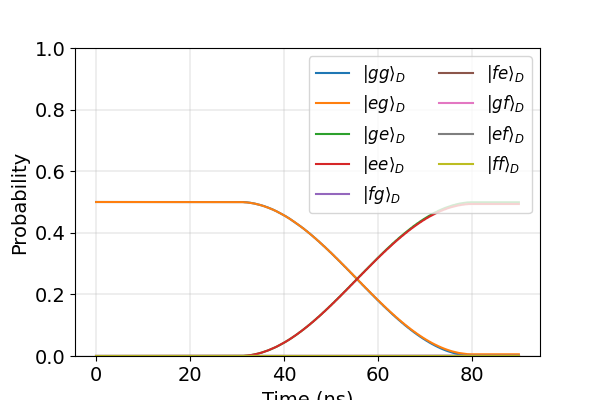

In [1466]:
eg = qram.state('eg')
gg = qram.state('gg')
ge = qram.state('ge')
ee = qram.state('ee')
fg = qram.state('fg')
fe = qram.state('fe')
gf = qram.state('gf')
ef = qram.state('ef')
ff = qram.state('ff')



prob_eg = [np.abs(eg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_gg = [np.abs(gg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ge = [np.abs(ge.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ee = [np.abs(ee.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_fg = [np.abs(fg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_fe = [np.abs(fe.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_gf = [np.abs(gf.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ef = [np.abs(ef.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ff = [np.abs(ff.overlap(result_rot[t]))**2 for t in range(len(times))]



fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4))

ax2.plot(times, prob_gg, label=r'$|gg\rangle_D$')
ax2.plot(times, prob_eg, label=r'$|eg\rangle_D$')
ax2.plot(times, prob_ge, label=r'$|ge\rangle_D$')
ax2.plot(times, prob_ee, label=r'$|ee\rangle_D$')
ax2.plot(times, prob_fg, label=r'$|fg\rangle_D$')
ax2.plot(times, prob_fe, label=r'$|fe\rangle_D$')
ax2.plot(times, prob_gf, label=r'$|gf\rangle_D$')
ax2.plot(times, prob_ef, label=r'$|ef\rangle_D$')
ax2.plot(times, prob_ff, label=r'$|ff\rangle_D$')


ax2.legend(fontsize=12, ncol=2)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Time (ns)', fontsize=14)
ax2.set_ylabel('Probability', fontsize=14)
ax2.grid(linewidth=0.3)


In [891]:
# partial trace on the final states to keep only the qubit subspace

U1 = np.zeros((cutoffs[0], cutoffs[0]))
U2 = np.zeros((cutoffs[1], cutoffs[1]))

U1[:2, :2] = qt.qeye(2).full()
U2[:2, :2] = qt.qeye(2).full()

U1 = qt.Qobj(U1)
U2 = qt.Qobj(U2)

P = qt.tensor(U1, U2).full()
zeros_P = np.argwhere(np.diag(P) != 0).flatten()


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_82407/352711901.py: 6ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_82407/352711901.py: 7

2


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_82407/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_82407/3308495072.py: 47

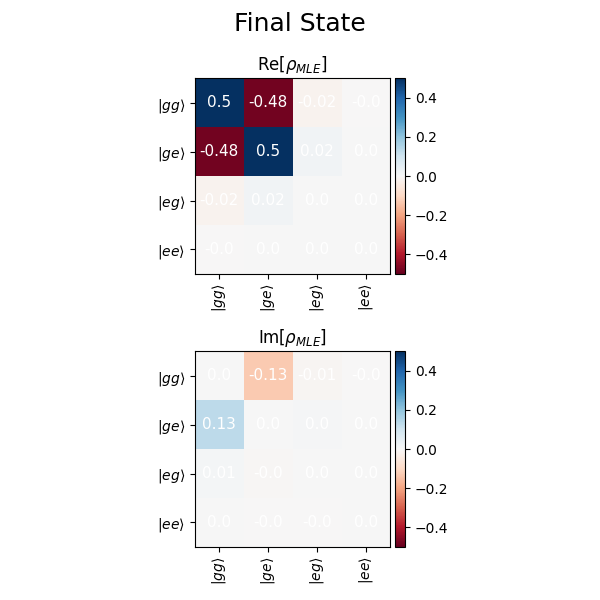

In [892]:
psi_plot = result_rot[-1]


psi_plot = psi_plot.full()[zeros_P]
psi_plot = qt.Qobj(psi_plot)
psi_plot.dims = [[2, 2], [1, 1]]
rho_plot = psi_plot*psi_plot.dag()

show_plot_rho_2d(rho_plot, title='Final State', cmax=0.5, figsize=(6, 6))

# Double drive swap

In [234]:
wsb =  np.abs(qram.qubit_freqs[1] -  qram.qubit_freqs[0])/2
wd1 = qram.qubit_freqs[1] + 0.150 + wsb
wd = qram.qubit_freqs[1] + 0.150 - wsb
amp1=0.2
qubit_drive = 1
# wd = qram.get_base_wd('eg', 'ge', wd1=2*np.pi*wd1, sideband='diff')
wd_plot = np.linspace(wd*0.99, wd*1.01, 50)

In [235]:
psi0 = qram.state('eg')
t_pulse = 100
times = np.linspace(0, t_pulse+10, 1000)
amp_vec = np.linspace(0.2, 0.6, 1)
prob_eg_tab = np.zeros((len(amp_vec), len(wd_plot)))
prob_ge_tab = np.zeros((len(amp_vec), len(wd_plot)))

for idx_w, w in tqdm(enumerate(wd_plot)):
    for idx_a, a in enumerate(amp_vec):
        seq = PulseSequence(start_time=0)

    
        drive1 = qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=amp1, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=wd1*2*np.pi, type='flat_top', t_rise=45, sigma_n=5)
        blue_drive = qram.add_sequential_pi_pulse(seq, 'gg', 'ge', amp=a, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=w*2*np.pi, t_offset=-t_pulse, type='flat_top', t_rise=45, sigma_n=5)


        result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=1000, progress=False)
        prob_eg = np.abs(eg.overlap(result[-1]))**2
        prob_ge = np.abs(ge.overlap(result[-1]))**2

        prob_eg_tab[idx_a, idx_w] = prob_eg
        prob_ge_tab[idx_a, idx_w] = prob_ge



50it [00:27,  1.85it/s]


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_49201/483897195.py: 4

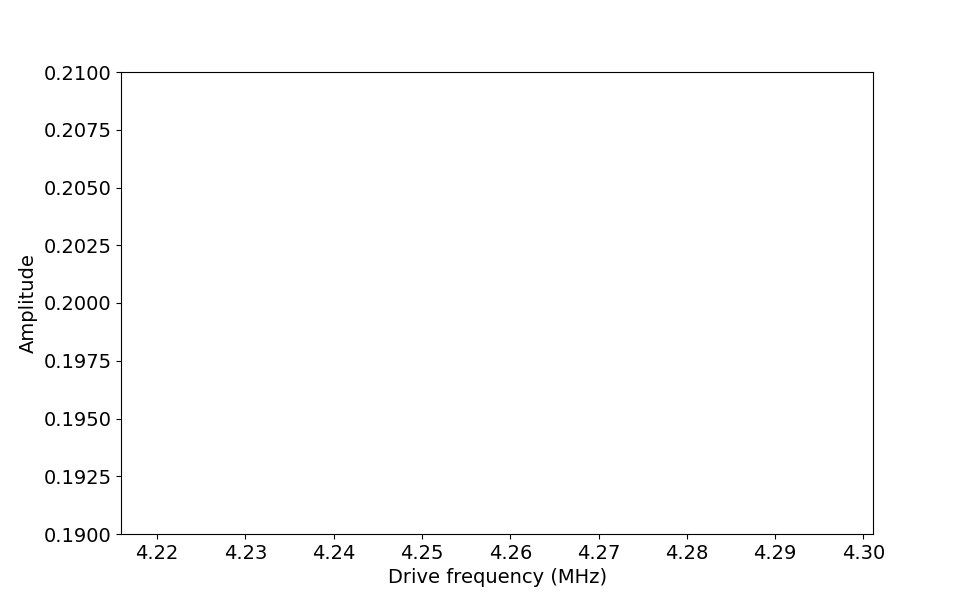

In [236]:
fig, ax = plt.subplots(1, 1)


ax.imshow(prob_ge_tab, aspect='auto', origin='lower', extent=[wd_plot[0], wd_plot[-1], amp_vec[0], amp_vec[-1]], cmap='viridis')

# ax.imshow(prob_ge_tab, aspect='auto', origin='lower', extent=[times[0], times[-1], w_blue_vec[0], w_blue_vec[-1]], cmap='viridis', vmin=0, vmax=1)
# ax.imshow(prob_eg_tab, aspect='auto', origin='lower', extent=[amp_vec[0], amp_vec[-1], wd_plot[0]/2/np.pi, wd_plot[-1]/2/np.pi], cmap='viridis', vmin=0, vmax=1)
# ax.imshow(prob_eg_tab, aspect='auto', origin='lower', extent=[amp_vec[0], amp_vec[-1], wd_plot[0]/2/np.pi, wd_plot[-1]/2/np.pi], cmap='viridis', vmin=0, vmax=1)

#add the simulated swap frequency

# ax.plot(times, w_blue*np.ones(len(times)), '--', lw=2)
# ax.plot(times, f1*np.ones(len(times)), '--', lw=2)
# ax.plot(times, f2*np.ones(len(times)), '--', lw=2)

ax.set_xlabel('Drive frequency (MHz)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

ax.tick_params(labelsize=14)

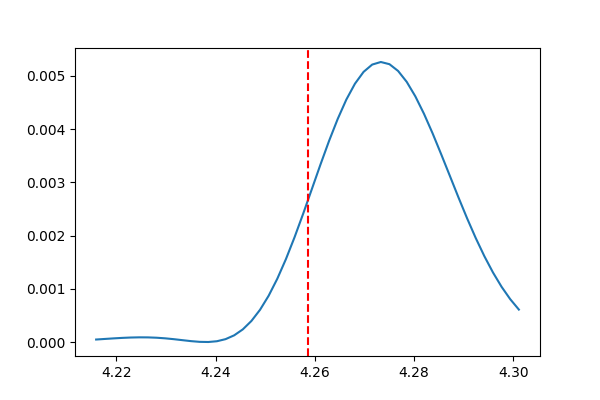

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(wd_plot, prob_ge_tab[0], label='|ge>') 

# vertical line for wd 

ax.axvline(x=wd, color='r', linestyle='--', label='wd')

In [1395]:
wd_plot[np.argmax(prob_ge_tab[0])]

42.73114337380798

In [245]:
wd1

5.574614409832909

In [243]:
wd2

4.273283815600727

In [248]:
wd1 = wd1
wd2 = wd_plot[np.argmax(prob_ge_tab[0])]
amp1 = amp1
amp2 = amp_vec[0]

t_pulse = 500

seq_1 = PulseSequence(start_time=0)

drive1 = qram.add_sequential_pi_pulse(seq_1, 'gg', 'eg', amp=amp1, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=wd1*2*np.pi, type='flat_top', t_rise=45, sigma_n=5)
drive2 = qram.add_sequential_pi_pulse(seq_1, 'gg', 'ge', amp=amp2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=wd2*2*np.pi, t_offset=-t_pulse, type='flat_top', t_rise=45, sigma_n=5)

times = np.linspace(1, seq_1.time + 10, 20)

psi0 = qram.state('eg')

prob_eg_t = np.zeros(len(times))
prob_ge_t = np.zeros(len(times))
prob_ee_t = np.zeros(len(times))
prob_gg_t = np.zeros(len(times))
prob_ff_t = np.zeros(len(times))
prob_fe_t = np.zeros(len(times))
prob_ef_t = np.zeros(len(times))
prob_fg_t = np.zeros(len(times))
prob_gf_t = np.zeros(len(times))

eg = qram.state('eg')
ge = qram.state('ge')
gg = qram.state('gg')
ee = qram.state('ee')
ef = qram.state('ef')
fe = qram.state('fe')
ff = qram.state('ff')
fg = qram.state('fg')
gf = qram.state('gf')

for t in tqdm(range(len(times))):
    t_vec = np.linspace(0, times[t], 5000) 
    result = qram.evolve(psi0, seq_1, t_vec, c_ops=None, nsteps=5000, progress=False)

    prob_eg_t[t] = np.abs(eg.overlap(result[-1]))**2
    prob_ge_t[t] = np.abs(ge.overlap(result[-1]))**2
    prob_ee_t[t] = np.abs(ee.overlap(result[-1]))**2
    prob_gg_t[t] = np.abs(gg.overlap(result[-1]))**2
    prob_ff_t[t] = np.abs(ff.overlap(result[-1]))**2
    prob_fe_t[t] = np.abs(fe.overlap(result[-1]))**2
    prob_ef_t[t] = np.abs(ef.overlap(result[-1]))**2
    prob_fg_t[t] = np.abs(fg.overlap(result[-1]))**2
    prob_gf_t[t] = np.abs(gf.overlap(result[-1]))**2






100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


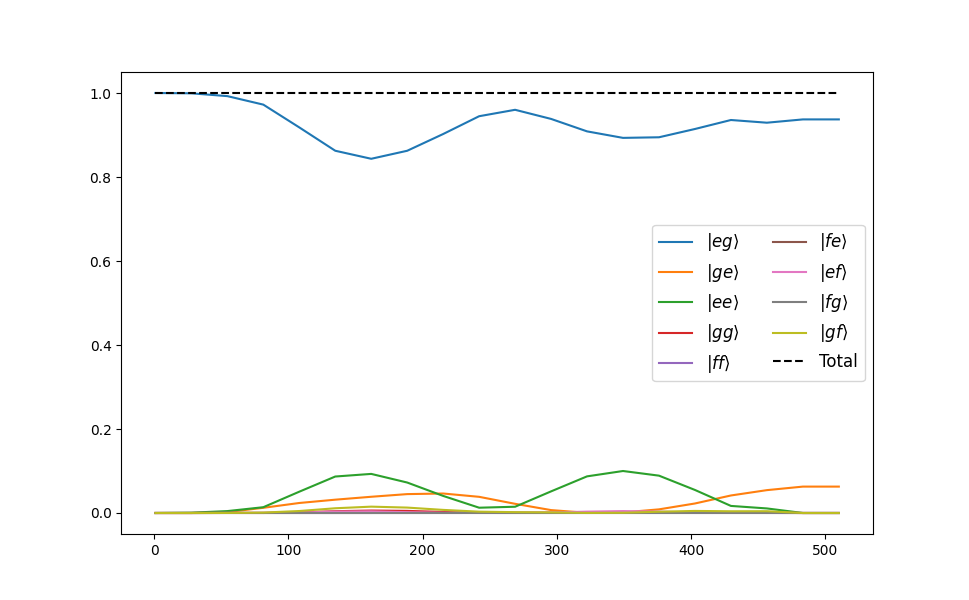

In [249]:
fig, ax = plt.subplots(1, 1)

ax.plot(times, prob_eg_t, label=r'$|eg\rangle$')
ax.plot(times, prob_ge_t, label=r'$|ge\rangle$')
ax.plot(times, prob_ee_t, label=r'$|ee\rangle$')
ax.plot(times, prob_gg_t, label=r'$|gg\rangle$')
ax.plot(times, prob_ff_t, label=r'$|ff\rangle$')
ax.plot(times, prob_fe_t, label=r'$|fe\rangle$')
ax.plot(times, prob_ef_t, label=r'$|ef\rangle$')
ax.plot(times, prob_fg_t, label=r'$|fg\rangle$')
ax.plot(times, prob_gf_t, label=r'$|gf\rangle$')

prop_tot = prob_eg_t + prob_ge_t + prob_ee_t + prob_gg_t + prob_ff_t + prob_fe_t + prob_ef_t + prob_fg_t + prob_gf_t

ax.plot(times, prop_tot, label='Total', color='black', linestyle='--')

ax.legend(fontsize=12, ncol=2)


# Sideband drive gates

In [1423]:
qram.qubit_freqs[1]

4.766561902541384

In [8]:
psi0 = qram.state('gg')
t_pulse = 200
qubit_drive=1
wd_stark = qram.qubit_freqs[1] + 0.150

w_sb = 0.05

amp_vec = np.linspace(0.01, 0.27, 5)


amp_pi = 0.01
wd_pi = qram.get_wd('gg', 'ge', amp=amp_pi, drive_qubit=qubit_drive, verbose=True, type='gauss')
tp = qram.get_Tpi(wd=wd_pi, state1='gg', state2='ge', amp=amp_pi, drive_qubit=qubit_drive, type='gauss',verbose=True)
wd_pi_vec = np.linspace(wd_pi*0.97, wd_pi*1.001, 10)
times = np.linspace(0, t_pulse, 1000)
prob_eg_tab = np.zeros((len(amp_vec), len(wd_pi_vec)))
prob_ge_tab = np.zeros((len(amp_vec), len(wd_pi_vec)))



for idx_a, a in enumerate(amp_vec):
    for idx_w, w in tqdm(enumerate(wd_pi_vec)):
        seq = PulseSequence(start_time=0)

        qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a/2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark - w_sb), t_rise=20) 
        qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a/2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark + w_sb), t_rise=20, t_offset=-t_pulse) 
        qram.add_sequential_pi_pulse(seq, 'gg', 'ge', amp=amp_pi, drive_qubit=qubit_drive, phase=0, t_pulse = tp, wd=w, t_offset=-t_pulse/2-tp*2, type='gauss')

        eg = qram.state('eg')
        ge = qram.state('ge')


        result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=1000, progress=False)

        # prog_ge_t = [np.abs(ge.overlap(result[t]))**2 for t in range(len(times))]

        # fig, ax = plt.subplots(1, 1)

        # ax.plot(times, prog_ge_t, label=r'$|eg\rangle$')

        prob_eg = np.abs(eg.overlap(result[-1]))**2
        prob_ge = np.abs(ge.overlap(result[-1]))**2


        prob_eg_tab[idx_a, idx_w] = prob_eg
        prob_ge_tab[idx_a, idx_w] = prob_ge



1
One photon transition
One qubit gate
wd_base 4.768758908170626
infidelity:  0.0008698805300075829
infidelity:  0.0008698784151378591
infidelity:  0.35721795459885763
infidelity:  0.35721796085015434
infidelity:  0.0012815459075109503
infidelity:  0.0012815497651157415
infidelity:  0.0006939417696522066
infidelity:  0.0006939417679705517
infidelity:  0.0006939416577496083
infidelity:  0.0006939416577513846


10it [00:06,  1.48it/s]
10it [00:07,  1.28it/s]
10it [00:08,  1.23it/s]
10it [00:08,  1.20it/s]
10it [00:08,  1.17it/s]


In [1643]:
# envelope_seq = seq.get_envelope_seq()
# pulse_amps = seq.get_pulse_amps()
# pulse_lens = seq.get_pulse_lengths()
# pulse_freq = seq.get_pulse_freqs()
# print(seq.get_pulse_freqs(), '(GHz)')
# print(pulse_lens, '(ns)')
# print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

# flat_times = np.array(times).flatten()

# fig, ax = plt.subplots(1, 1)

# print(flat_times)
# for i in range(len(envelope_seq)):
#     ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
# ax.set_xlabel('Time (ns)')
# ax.set_ylabel('Drive Amplitude (MHz)')
# # plt.xlim(0, 200)
# ax.set_title('Pulse Sequence')
# ax.legend()


In [1644]:
tp

20.91538394081396

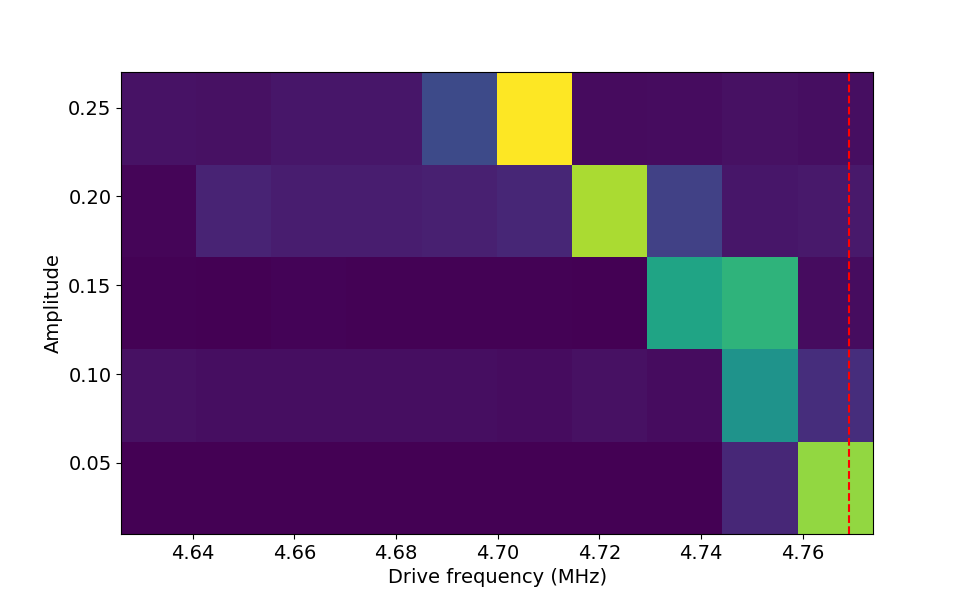

In [9]:
fig, ax = plt.subplots(1, 1)


ax.imshow(prob_ge_tab, aspect='auto', origin='lower', extent=[wd_pi_vec[0]/2/np.pi, wd_pi_vec[-1]/2/np.pi, amp_vec[0], amp_vec[-1]], cmap='viridis')

# ax.imshow(prob_ge_tab, aspect='auto', origin='lower', extent=[times[0], times[-1], w_blue_vec[0], w_blue_vec[-1]], cmap='viridis', vmin=0, vmax=1)
# ax.imshow(prob_eg_tab, aspect='auto', origin='lower', extent=[amp_vec[0], amp_vec[-1], wd_plot[0]/2/np.pi, wd_plot[-1]/2/np.pi], cmap='viridis', vmin=0, vmax=1)
# ax.imshow(prob_eg_tab, aspect='auto', origin='lower', extent=[amp_vec[0], amp_vec[-1], wd_plot[0]/2/np.pi, wd_plot[-1]/2/np.pi], cmap='viridis', vmin=0, vmax=1)

#add the simulated swap frequency

# ax.plot(times, w_blue*np.ones(len(times)), '--', lw=2)
# ax.plot(times, f1*np.ones(len(times)), '--', lw=2)
# ax.plot(times, f2*np.ones(len(times)), '--', lw=2)

# horizontal line at wp_pi

ax.axvline(wd_pi/2/np.pi, color='red', linestyle='--', label='wd_pi')



ax.set_xlabel('Drive frequency (MHz)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

ax.tick_params(labelsize=14)

In [10]:
psi0 = qram.state('gg')
t_pulse = 250
t_rise = 50
qubit_drive=1
wd_stark = qram.qubit_freqs[1] + 0.150
w_sb = 0.01*3
amp = 0.25


w_sb = np.linspace(0.01, 0.1, 20)

seq = PulseSequence(start_time=0)


amp_pi = 0.04
wd_pi = qram.get_wd('gg', 'ge', amp=amp_pi, drive_qubit=qubit_drive, verbose=True, type='gauss')
tp = qram.get_Tpi(wd=wd_pi, state1='gg', state2='ge', amp=amp_pi, drive_qubit=qubit_drive, type='gauss',verbose=True)
t_start = t_rise + np.linspace(0, t_pulse-2*t_rise-tp*4, 100)
times = np.linspace(0, t_pulse, 1000)
# prob_ge_tab = np.zeros(len(t_start))
prob_ge_tab = np.zeros((len(t_start), len(w_sb)))


1
One photon transition
One qubit gate
wd_base 4.768758908170626
infidelity:  0.013551357959611265
infidelity:  0.013551355665996523
infidelity:  0.12222971338704114
infidelity:  0.12222972090835382
infidelity:  0.010387381056189193
infidelity:  0.010387380816986758
infidelity:  0.010353284046877964
infidelity:  0.010353284050225064
infidelity:  0.010353277365944713
infidelity:  0.0103532773659466


In [1741]:
w_sb

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [11]:
for idx_w, w in tqdm(enumerate(w_sb)):
        for idx_t, t in enumerate(t_start):
        
                seq = PulseSequence(start_time=0)

                qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a/2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark - w), t_rise=t_rise) 
                qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a/2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark + w), t_rise=t_rise, t_offset=-t_pulse) 
                qram.add_sequential_pi_pulse(seq, 'gg', 'ge', amp=amp_pi, drive_qubit=qubit_drive, phase=0, t_pulse = tp, wd=wd_pi, t_offset=-t_pulse+t, type='gauss')

                eg = qram.state('eg')
                ge = qram.state('ge')


                result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=1000, progress=False)

                # prog_ge_t = [np.abs(ge.overlap(result[t]))**2 for t in range(len(times))]

                # fig, ax = plt.subplots(1, 1)

                # ax.plot(times, prog_ge_t, label=r'$|eg\rangle$')

                prob_ge = np.abs(ge.overlap(result[-1]))**2


                prob_ge_tab[idx_t, idx_w] = prob_ge

0it [00:00, ?it/s]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
0it [00:08, ?it/s]


KeyboardInterrupt: 

In [1743]:
# envelope_seq = seq.get_envelope_seq()
# pulse_amps = seq.get_pulse_amps()
# pulse_lens = seq.get_pulse_lengths()
# pulse_freq = seq.get_pulse_freqs()

# flat_times = np.array(times).flatten()

# fig, ax = plt.subplots(1, 1)
# for i in range(len(envelope_seq)):
#     ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
# ax.set_xlabel('Time (ns)')
# ax.set_ylabel('Drive Amplitude (MHz)')
# # plt.xlim(0, 200)
# ax.set_title('Pulse Sequence')
# ax.legend()

5it [00:00, 2994.22it/s]


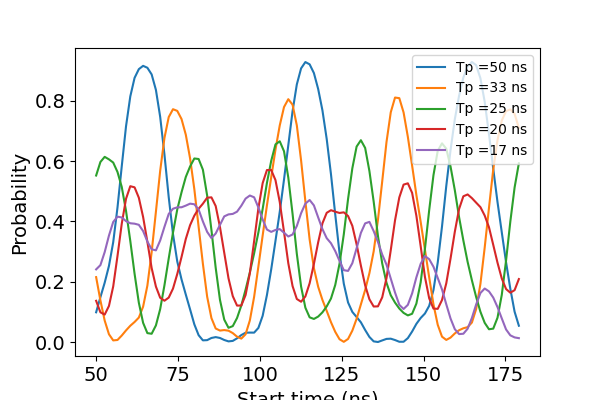

In [1745]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

for idx_w, w in tqdm(enumerate(w_sb[:5])):

    ax.plot(t_start, prob_ge_tab[:,idx_w], label='Tp =%d ns' %(1/w/2))

ax.set_xlabel('Start time (ns)', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.legend()

ax.tick_params(labelsize=14)


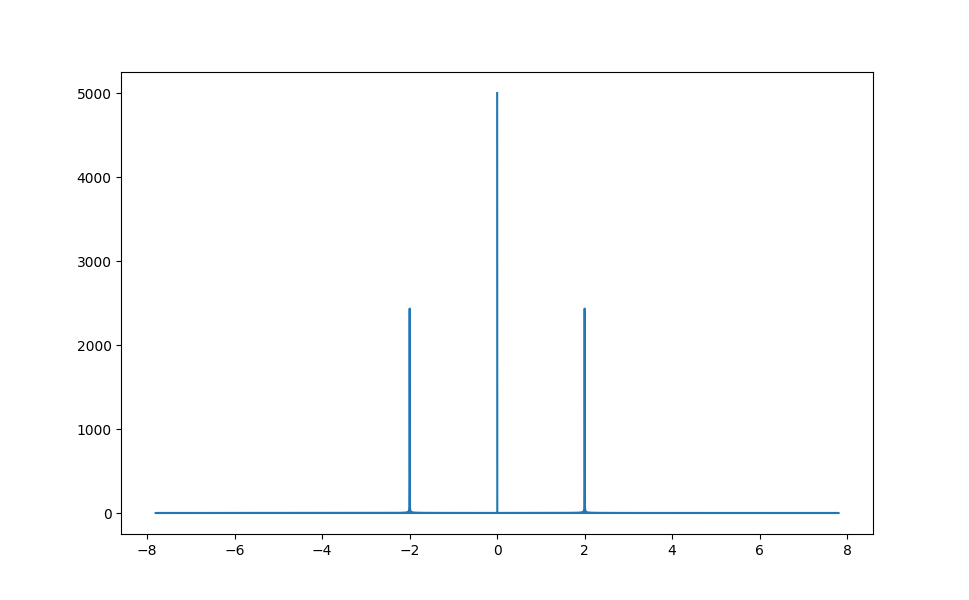

In [265]:
# take the fourier transform of the signal 
f = 3.2*2
x = np.linspace(0, 100, 10000)*2*np.pi
y = np.abs(np.cos(f*x))**2

x_fft = fftfreq(len(x), x[1] - x[0])
y_fft = fft(y)

fig, ax = plt.subplots(1, 1)

ax.plot(x_fft/f*2*np.pi, np.abs(y_fft))

## sideband? 

In [253]:
psi0 = qram.state('eg')
qubit_drive=1
wd_stark = qram.qubit_freqs[1] + 0.150
w_sb = np.abs(qram.qubit_freqs[1] - qram.qubit_freqs[0])/2
wd_sb_vec = np.linspace(w_sb*0.98, w_sb*1, 50)
amp_swap = 0.25
t_rise = 45
amp_vec = np.linspace(0.0001,amp_swap, 10) 


t_pulse = 200
times = np.linspace(0, t_pulse+10, 1000)

prob_eg_tab = np.zeros((len(amp_vec), len(wd_sb_vec)))
prob_ge_tab = np.zeros((len(amp_vec), len(wd_sb_vec)))


for idx_a, a in enumerate(amp_vec):
    for idx_w, w in tqdm(enumerate(wd_sb_vec)):
        seq = PulseSequence(start_time=0)


        drive_1 = qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark - w), type='flat_top',
                                        t_rise=t_rise, sigma_n=5) 
        drive_2 = qram.add_sequential_pi_pulse(seq, 'gg', 'eg', amp=a, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark + w), type='flat_top',
                                        t_offset=-t_pulse, t_rise=t_rise, sigma_n=5)


        eg = qram.state('eg')
        ge = qram.state('ge')
        result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=1000, progress=False)

        # prog_ge_t = [np.abs(ge.overlap(result[t]))**2 for t in range(len(times))]

        # fig, ax = plt.subplots(1, 1)

        # ax.plot(times, prog_ge_t, label=r'$|eg\rangle$')

        prob_eg = np.abs(eg.overlap(result[-1]))**2
        prob_ge = np.abs(ge.overlap(result[-1]))**2


        prob_eg_tab[idx_a, idx_w] = prob_eg
        prob_ge_tab[idx_a, idx_w] = prob_ge


50it [00:24,  2.02it/s]
50it [00:32,  1.54it/s]
50it [00:34,  1.46it/s]
50it [00:36,  1.37it/s]
50it [00:37,  1.33it/s]
50it [00:38,  1.29it/s]
50it [00:41,  1.21it/s]
50it [00:41,  1.21it/s]
50it [00:42,  1.17it/s]
50it [00:42,  1.17it/s]


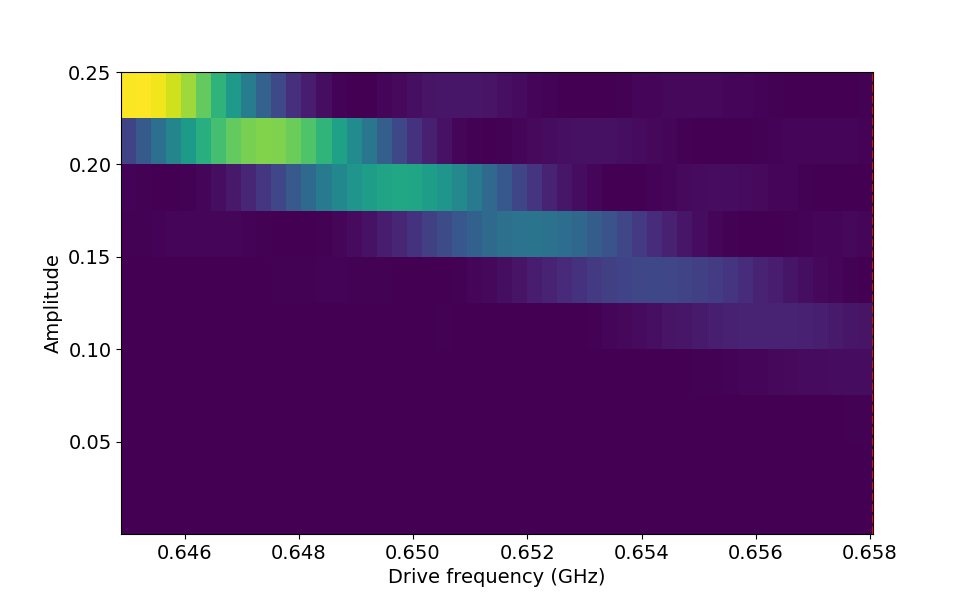

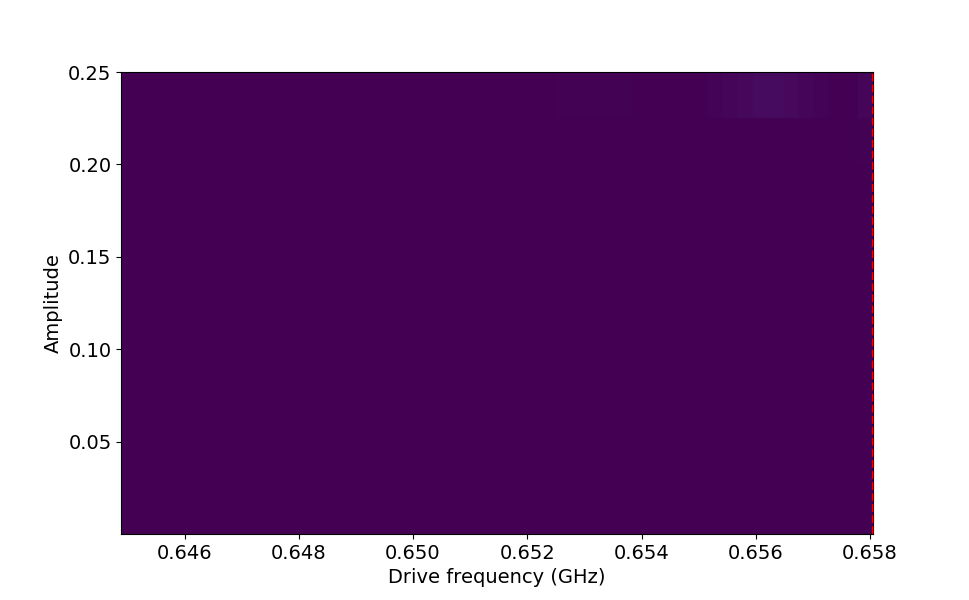

In [254]:
fig, ax = plt.subplots(1, 1)


ax.imshow(prob_ge_tab, aspect='auto', origin='lower', extent=[wd_sb_vec[0], wd_sb_vec[-1], amp_vec[0], 
                                                              amp_vec[-1]], cmap='viridis', vmin = 0)
ax.axvline(w_sb, color='red', linestyle='--', label='wd_pi')

ax.set_xlabel('Drive frequency (GHz)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

ax.tick_params(labelsize=14)

fig, ax = plt.subplots(1, 1)
ax.imshow(1 - (prob_ge_tab + prob_eg_tab), aspect='auto', origin='lower', extent=[wd_sb_vec[0], wd_sb_vec[-1], amp_vec[0], amp_vec[-1]],
           cmap='viridis', vmin = 0, vmax=1)
ax.axvline(w_sb, color='red', linestyle='--', label='wd_pi')

ax.set_xlabel('Drive frequency (GHz)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

ax.tick_params(labelsize=14)


In [211]:
amp_swap = 0.25
idx_swap = np.argmin(np.abs(amp_vec - amp_swap))
amp1 = amp_vec[idx_swap]
amp2 = amp_vec[idx_swap]
idx_sb = np.argmax(prob_ge_tab[idx_swap,:])
t_pulse = 500
t_rise = 45
seq_1 = PulseSequence(start_time=0)
drive_1 = qram.add_sequential_pi_pulse(seq_1, 'gg', 'eg', amp=amp1, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark - wd_sb_vec[idx_sb]), type='flat_top',
                                        t_rise=t_rise, sigma_n=5) 
drive_2 = qram.add_sequential_pi_pulse(seq_1, 'gg', 'eg', amp=amp2, drive_qubit=qubit_drive, phase=0, t_pulse = t_pulse, wd=2*np.pi*(wd_stark + wd_sb_vec[idx_sb]), type='flat_top',
                                        t_offset=-t_pulse, t_rise=t_rise, sigma_n=5)



[4.271401852535571, 5.561721952547197] (GHz)
[500 500] (ns)
total pulse length 1000 ns
[  0.           1.02204409   2.04408818   3.06613226   4.08817635
   5.11022044   6.13226453   7.15430862   8.17635271   9.19839679
  10.22044088  11.24248497  12.26452906  13.28657315  14.30861723
  15.33066132  16.35270541  17.3747495   18.39679359  19.41883768
  20.44088176  21.46292585  22.48496994  23.50701403  24.52905812
  25.5511022   26.57314629  27.59519038  28.61723447  29.63927856
  30.66132265  31.68336673  32.70541082  33.72745491  34.749499
  35.77154309  36.79358717  37.81563126  38.83767535  39.85971944
  40.88176353  41.90380762  42.9258517   43.94789579  44.96993988
  45.99198397  47.01402806  48.03607214  49.05811623  50.08016032
  51.10220441  52.1242485   53.14629259  54.16833667  55.19038076
  56.21242485  57.23446894  58.25651303  59.27855711  60.3006012
  61.32264529  62.34468938  63.36673347  64.38877756  65.41082164
  66.43286573  67.45490982  68.47695391  69.498998    70.5

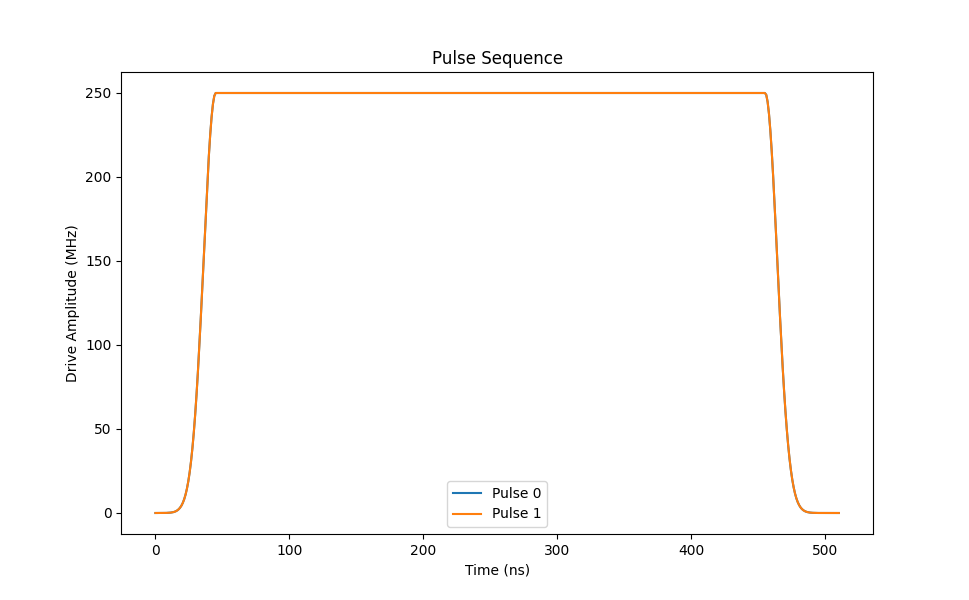

In [212]:
envelope_seq = seq_1.get_envelope_seq()
pulse_amps = seq_1.get_pulse_amps()
pulse_lens = seq_1.get_pulse_lengths()
pulse_freq = seq_1.get_pulse_freqs()
print(seq_1.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq_1.get_pulse_lengths()), 'ns')

times = np.linspace(0, seq_1.time + 10, 500)
flat_times = np.array(times).flatten()

fig, ax = plt.subplots(1, 1)

print(flat_times)
for i in range(len(envelope_seq)):
    ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 200)
ax.set_title('Pulse Sequence')
ax.legend()


In [213]:
times = np.linspace(1, seq_1.time + 10, 20)

psi0 = qram.state('eg')

prob_eg_t = np.zeros(len(times))
prob_ge_t = np.zeros(len(times))
prob_ee_t = np.zeros(len(times))
prob_gg_t = np.zeros(len(times))
prob_ff_t = np.zeros(len(times))
prob_fe_t = np.zeros(len(times))
prob_ef_t = np.zeros(len(times))
prob_fg_t = np.zeros(len(times))
prob_gf_t = np.zeros(len(times))

eg = qram.state('eg')
ge = qram.state('ge')
gg = qram.state('gg')
ee = qram.state('ee')
ef = qram.state('ef')
fe = qram.state('fe')
ff = qram.state('ff')
fg = qram.state('fg')
gf = qram.state('gf')

for t in tqdm(range(len(times))):
    t_vec = np.linspace(0, times[t], 5000) 
    result = qram.evolve(psi0, seq_1, t_vec, c_ops=None, nsteps=5000, progress=False)

    prob_eg_t[t] = np.abs(eg.overlap(result[-1]))**2
    prob_ge_t[t] = np.abs(ge.overlap(result[-1]))**2
    prob_ee_t[t] = np.abs(ee.overlap(result[-1]))**2
    prob_gg_t[t] = np.abs(gg.overlap(result[-1]))**2
    prob_ff_t[t] = np.abs(ff.overlap(result[-1]))**2
    prob_fe_t[t] = np.abs(fe.overlap(result[-1]))**2
    prob_ef_t[t] = np.abs(ef.overlap(result[-1]))**2
    prob_fg_t[t] = np.abs(fg.overlap(result[-1]))**2
    prob_gf_t[t] = np.abs(gf.overlap(result[-1]))**2



100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


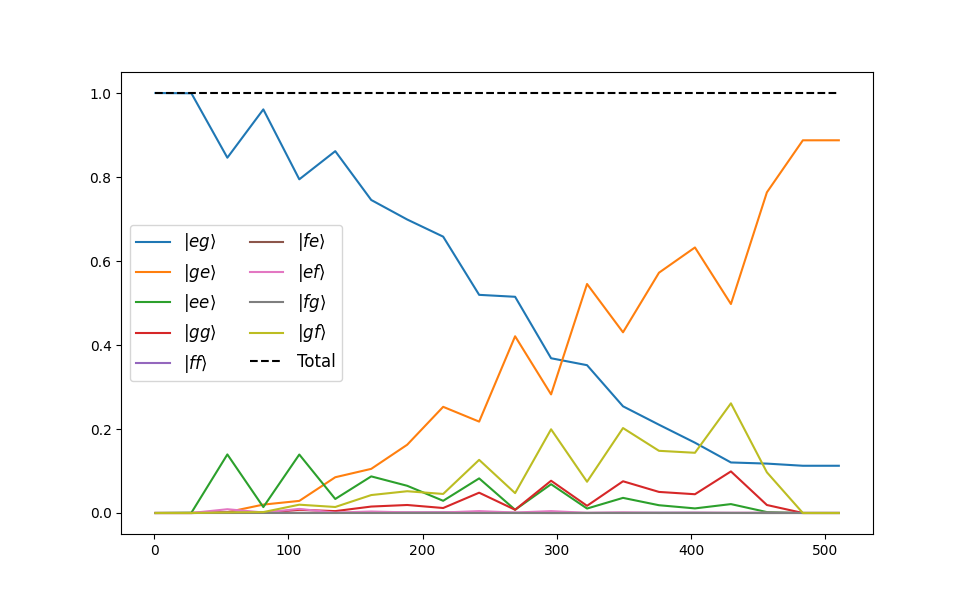

In [214]:
fig, ax = plt.subplots(1, 1)

ax.plot(times, prob_eg_t, label=r'$|eg\rangle$')
ax.plot(times, prob_ge_t, label=r'$|ge\rangle$')
ax.plot(times, prob_ee_t, label=r'$|ee\rangle$')
ax.plot(times, prob_gg_t, label=r'$|gg\rangle$')
ax.plot(times, prob_ff_t, label=r'$|ff\rangle$')
ax.plot(times, prob_fe_t, label=r'$|fe\rangle$')
ax.plot(times, prob_ef_t, label=r'$|ef\rangle$')
ax.plot(times, prob_fg_t, label=r'$|fg\rangle$')
ax.plot(times, prob_gf_t, label=r'$|gf\rangle$')

prop_tot = prob_eg_t + prob_ge_t + prob_ee_t + prob_gg_t + prob_ff_t + prob_fe_t + prob_ef_t + prob_fg_t + prob_gf_t

ax.plot(times, prop_tot, label='Total', color='black', linestyle='--')

ax.legend(fontsize=12, ncol=2)

In [180]:
1 - prob_eg_t[-1] - prob_ge_t[-1]

3.5722917101979612e-06